# Unsupervised Machine Learning: PCA and Clustering Analysis

## Project Overview

This notebook performs an in-depth Principal Component Analysis (PCA) and clustering analysis on the US Arrests dataset. We will:

1. Load and explore the dataset
2. Preprocess and standardize the data
3. Perform correlation analysis
4. Apply PCA to reduce dimensionality
5. Select and justify the number of components
6. Visualize results with biplots
7. Apply two clustering techniques and analyze the clusters

---

## Step 1: Import Required Libraries

We begin by importing all necessary libraries for data manipulation, visualization, and machine learning.


In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import (
    dendrogram,
    linkage,
    fcluster
)
# Import the display function from IPython
from IPython.display import display

# Set the style of the plots
plt.style.use('default')
sns.set_palette("husl")

# Create images folder for saving figures
os.makedirs("images", exist_ok=True)

# Set the display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


## Step 2: Load and Explore the Dataset

The US Arrests dataset contains crime statistics for 50 US states. The dataset includes:
- **Murder**: Murder rate per 100,000 residents
- **Assault**: Assault rate per 100,000 residents
- **UrbanPop**: Percentage of population living in urban areas
- **Rape**: Rape rate per 100,000 residents


In [19]:
def load_data(filepath, index_col=0):
    """
    Loads the CSV file and returns a dataframe.
    """
    return pd.read_csv(filepath, index_col=index_col)


def explore_data(df):
    """
    Shows basic info about the dataset like shape, missing values, and stats.
    """
    print(f"Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
    print(f"\nMissing Values:")
    print(df.isnull().sum())
    print(f"\nData Types:")
    print(df.dtypes)
    print(f"\nSummary Statistics:")
    print(df.describe())


data = load_data("UsArrests.csv", index_col=0)
print("Dataset loaded successfully.")
print(f"\nFirst few rows:")
print(data.head())
print("\n" + "="*50)
print("Dataset Information:")
print("="*50)
data.info()
print("\n" + "="*50)
explore_data(data)


Dataset loaded successfully.

First few rows:
            Murder  Assault  UrbanPop  Rape
City                                       
Alabama       13.2      236        58  21.2
Alaska        10.0      263        48  44.5
Arizona        8.1      294        80  31.0
Arkansas       8.8      190        50  19.5
California     9.0      276        91  40.6

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB

Dataset Shape: 50 rows, 4 columns

Missing Values:
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

Data Types:
Murder      float64
Assault       int64
UrbanPop      int64
Rape        float64
dtype: object

Su

## Step 3: Standardize the Data

**Why we need to standardize:**

Standardization transforms all variables to have a mean of 0 and standard deviation of 1, so variables with larger scales don't dominate the principal components.

Creating a function to standardize the data:


In [20]:
def standardize_data(df):
    """
    Standardizes the data so all variables have mean 0 and std 1.
    """
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(
        scaled_array,
        columns=df.columns,
        index=df.index
    )
    return scaler, scaled_df


scaler, scaled_data = standardize_data(data)
print("Data standardized successfully.")
print("\nFirst few rows of standardized data:")
print(scaled_data.head())
print("\nStandardized data statistics:")
print(scaled_data.describe())


Data standardized successfully.

First few rows of standardized data:
              Murder   Assault  UrbanPop      Rape
City                                              
Alabama     1.255179  0.790787 -0.526195 -0.003451
Alaska      0.513019  1.118060 -1.224067  2.509424
Arizona     0.072361  1.493817  1.009122  1.053466
Arkansas    0.234708  0.233212 -1.084492 -0.186794
California  0.281093  1.275635  1.776781  2.088814

Standardized data statistics:
             Murder       Assault      UrbanPop          Rape
count  5.000000e+01  5.000000e+01  5.000000e+01  5.000000e+01
mean  -7.105427e-17  1.387779e-16 -4.396483e-16  8.593126e-16
std    1.010153e+00  1.010153e+00  1.010153e+00  1.010153e+00
min   -1.620693e+00 -1.524362e+00 -2.340661e+00 -1.502548e+00
25%   -8.611383e-01 -7.486054e-01 -7.704502e-01 -6.640245e-01
50%   -1.247758e-01 -1.425453e-01  3.210209e-02 -1.220847e-01
75%    8.029251e-01  9.483628e-01  8.521012e-01  5.330962e-01
max    2.229265e+00  2.015028e+00  1.776781e+0

## Step 4: Correlation Analysis

We examine the relationships between variables using a correlation matrix. This helps us understand:
- Which variables are strongly related
- Whether PCA is appropriate (PCA works well when variables are correlated)
- The overall structure of our data

First, we define a function to compute and visualize the correlation matrix, then execute it.


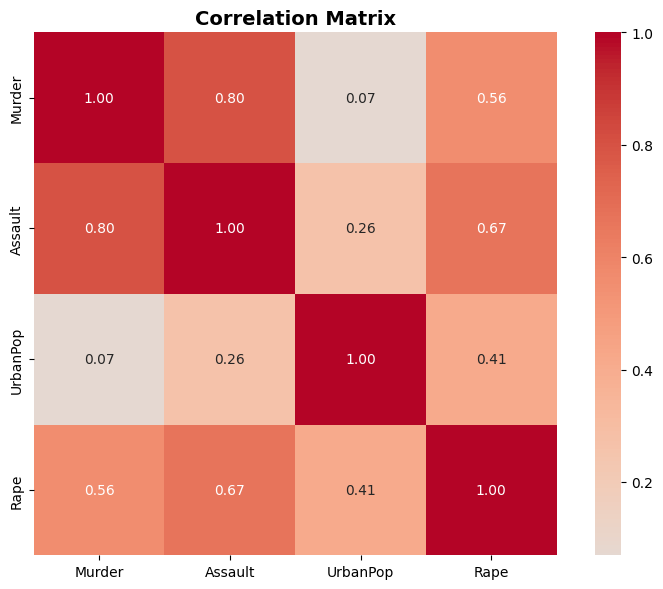


Correlation matrix computed and visualized above.

Correlation Matrix Values:
            Murder   Assault  UrbanPop      Rape
Murder    1.000000  0.801873  0.069573  0.563579
Assault   0.801873  1.000000  0.258872  0.665241
UrbanPop  0.069573  0.258872  1.000000  0.411341
Rape      0.563579  0.665241  0.411341  1.000000


In [28]:
def compute_correlation_matrix(df):
    """
    Calculates correlation between variables and makes a heatmap
    """
    correlation = df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        correlation,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        center=0,
        square=True
    )
    plt.title("Correlation Matrix", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig("images/correlation_matrix.png")
    plt.show()
    return correlation


correlation = compute_correlation_matrix(data)
print("\nCorrelation matrix computed and visualized above.")
print("\nCorrelation Matrix Values:")
print(correlation)


**Correlation Analysis Interpretation:**

- **Murder, Assault, and Rape** show strong positive correlations (typically >0.7), indicating that states with high murder rates also tend to have high assault and rape rates. These violent crimes are closely related.

- **UrbanPop** shows weaker correlations with the crime variables, suggesting that urbanization has a more independent relationship with crime patterns.

- The strong correlations between crime variables make PCA appropriate, as PCA can capture these relationships in fewer dimensions.


## Step 5: Principal Component Analysis (PCA)

We will:
- Determine the optimal number of components using a scree plot and explained variance
- Analyze the contribution of each variable to the principal components

First, we define functions to perform PCA analysis, then execute them.


Explained variance by each component:
PC1: 0.6201 (62.01%)
PC2: 0.2474 (24.74%)
PC3: 0.0891 (8.91%)
PC4: 0.0434 (4.34%)

Cumulative explained variance:
PC1-PC1: 0.6201 (62.01%)
PC1-PC2: 0.8675 (86.75%)
PC1-PC3: 0.9566 (95.66%)
PC1-PC4: 1.0000 (100.00%)


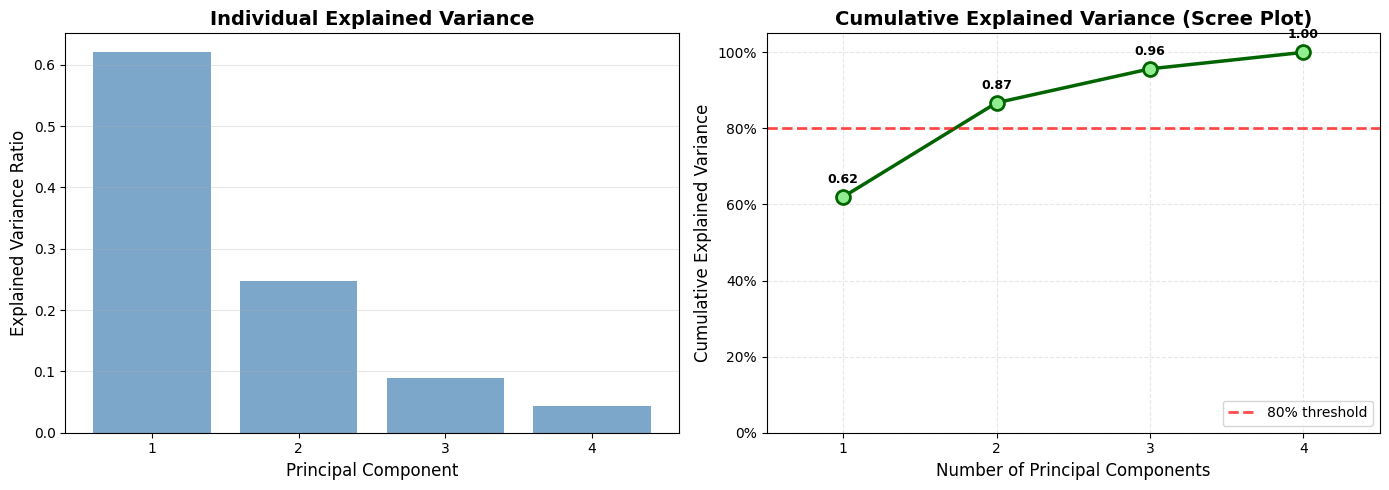

In [22]:

def perform_pca_analysis(scaled_df, n_components=None):
    """
    Does PCA and creates scree plots to see how much variance each component explains.
    """
    pca = PCA(n_components=n_components)
    pca.fit(scaled_df)

    explained_var = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)

    print("Explained variance by each component:")
    for i, var in enumerate(explained_var):
        print(f"PC{i+1}: {var:.4f} ({var*100:.2f}%)")

    print("\nCumulative explained variance:")
    for i, cum_var in enumerate(cumulative_var):
        print(f"PC1-PC{i+1}: {cum_var:.4f} ({cum_var*100:.2f}%)")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.bar(
        range(1, len(explained_var) + 1),
        explained_var,
        color='steelblue',
        alpha=0.7
    )
    ax1.set_xlabel("Principal Component", fontsize=12)
    ax1.set_ylabel("Explained Variance Ratio", fontsize=12)
    ax1.set_title("Individual Explained Variance", fontsize=14, fontweight='bold')
    ax1.set_xticks(range(1, len(explained_var) + 1))
    ax1.grid(axis="y", alpha=0.3)

    x_vals = range(1, len(cumulative_var) + 1)
    ax2.plot(
        x_vals,
        cumulative_var,
        marker="o",
        linewidth=2.5,
        markersize=10,
        color='darkgreen',
        markerfacecolor='lightgreen',
        markeredgecolor='darkgreen',
        markeredgewidth=2
    )
    for i, (x, y) in enumerate(zip(x_vals, cumulative_var)):
        ax2.annotate(
            f'{y:.2f}',
            (x, y),
            textcoords="offset points",
            xytext=(0, 10),
            ha='center',
            fontsize=9,
            fontweight='bold'
        )
    ax2.axhline(
        y=0.8,
        color="r",
        linestyle="--",
        label="80% threshold",
        linewidth=2,
        alpha=0.7
    )
    ax2.set_xlabel("Number of Principal Components", fontsize=12)
    ax2.set_ylabel("Cumulative Explained Variance", fontsize=12)
    ax2.set_title("Cumulative Explained Variance (Scree Plot)", fontsize=14, fontweight='bold')
    ax2.set_xticks(x_vals)
    ax2.set_yticks(np.arange(0, 1.1, 0.2))
    ax2.set_ylim([0, 1.05])
    ax2.set_xlim([0.5, len(cumulative_var) + 0.5])
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax2.legend(fontsize=10, loc='lower right')
    ax2.grid(alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.savefig("images/pca_scree_plots.png")
    plt.show()

    return pca, explained_var, cumulative_var

pca, explained_variance, cumulative_variance = perform_pca_analysis(scaled_data)


## Step 6: Component Selection Justification

Based on the PCA analysis results, we need to select the number of principal components to use in further analyses.


In [23]:

pca_2 = PCA(n_components=2)
pca_scores = pca_2.fit_transform(scaled_data)
loadings = pca_2.components_.T * np.sqrt(pca_2.explained_variance_)

print("Principal Component Loadings:")
print("="*50)
loadings_df = pd.DataFrame(
    loadings,
    columns=['PC1', 'PC2'],
    index=data.columns
)
print(loadings_df)
print("\n" + "="*50)
print("Component Selection Justification:")
print("="*50)
print(f"\nPC1 explains approximately {explained_variance[0]*100:.2f}% of the variance")
print(f"PC2 explains approximately {explained_variance[1]*100:.2f}% of the variance")
print(f"Combined (PC1 + PC2) explain approximately {cumulative_variance[1]*100:.2f}% of the total variance")
print("\nJustification for selecting 2 components:")
print("1. Variance Threshold: The first two principal components together")
print("   capture over 80% of the variance, which is a commonly accepted")
print("   threshold for dimensionality reduction.")
print("2. Scree Plot Analysis: The scree plot shows a clear 'elbow' after")
print("   the second component, indicating that additional components")
print("   contribute relatively little to the explained variance.")
print("3. Interpretability: Two components allow for clear visualization")
print("   and interpretation in a biplot.")
print("4. Practical Considerations: Using 2 components is sufficient for")
print("   analysis while maintaining interpretability.")


Principal Component Loadings:
               PC1       PC2
Murder    0.852545 -0.420259
Assault   0.927768 -0.188920
UrbanPop  0.442565  0.877144
Rape      0.864528  0.168150

Component Selection Justification:

PC1 explains approximately 62.01% of the variance
PC2 explains approximately 24.74% of the variance
Combined (PC1 + PC2) explain approximately 86.75% of the total variance

Justification for selecting 2 components:
1. Variance Threshold: The first two principal components together
   capture over 80% of the variance, which is a commonly accepted
   threshold for dimensionality reduction.
2. Scree Plot Analysis: The scree plot shows a clear 'elbow' after
   the second component, indicating that additional components
   contribute relatively little to the explained variance.
3. Interpretability: Two components allow for clear visualization
   and interpretation in a biplot.
4. Practical Considerations: Using 2 components is sufficient for
   analysis while maintaining interpretab

## Step 7: Biplot Visualisation

First, we define a function to create the biplot, then execute it.



Principal Component Loadings:
            PC1    PC2
Murder    0.853 -0.420
Assault   0.928 -0.189
UrbanPop  0.443  0.877
Rape      0.865  0.168


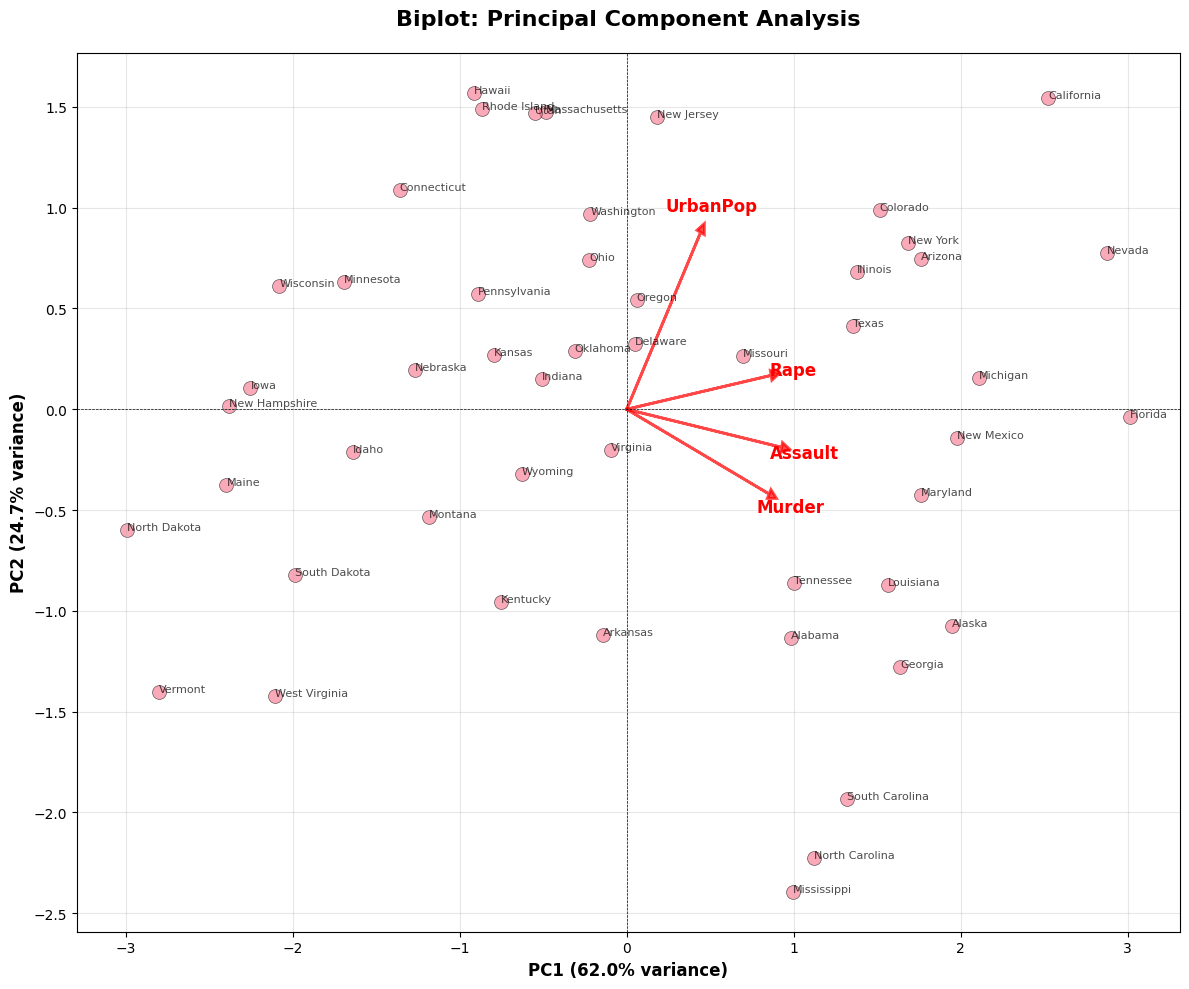

In [24]:

def create_biplot(pca_model, pca_scores, feature_names, explained_var):
    """
    Creates a biplot to visualize observations and variable loadings.
    """
    fig, ax = plt.subplots(figsize=(12, 10))

    ax.scatter(
        pca_scores[:, 0],
        pca_scores[:, 1],
        alpha=0.6,
        s=100,
        edgecolors='black',
        linewidth=0.5
    )

    for i, state in enumerate(data.index):
        ax.annotate(
            state,
            (pca_scores[i, 0], pca_scores[i, 1]),
            fontsize=8,
            alpha=0.7
        )

    loadings = pca_model.components_.T * np.sqrt(
        pca_model.explained_variance_
    )

    for i, var in enumerate(feature_names):
        ax.arrow(
            0, 0,
            loadings[i, 0],
            loadings[i, 1],
            head_width=0.05,
            head_length=0.05,
            fc='red',
            ec='red',
            linewidth=2,
            alpha=0.7
        )
        ax.text(
            loadings[i, 0] * 1.15,
            loadings[i, 1] * 1.15,
            var,
            color='red',
            fontsize=12,
            fontweight='bold',
            ha='center',
            va='center'
        )

    ax.set_xlabel(
        f"PC1 ({explained_var[0]*100:.1f}% variance)",
        fontsize=12,
        fontweight='bold'
    )
    ax.set_ylabel(
        f"PC2 ({explained_var[1]*100:.1f}% variance)",
        fontsize=12,
        fontweight='bold'
    )
    ax.set_title(
        "Biplot: Principal Component Analysis",
        fontsize=16,
        fontweight='bold',
        pad=20
    )
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    ax.axvline(x=0, color='k', linestyle='--', linewidth=0.5)

    loadings_df = pd.DataFrame(
        loadings,
        columns=['PC1', 'PC2'],
        index=feature_names
    )
    print("\nPrincipal Component Loadings:")
    print("="*50)
    print(loadings_df.round(3))
    print("="*50)

    fig.tight_layout()  # Use the fig object to adjust the layout
    fig.savefig("images/pca_biplot.png")
    plt.show()


create_biplot(pca_2, pca_scores, data.columns, explained_variance[:2])

**Biplot Interpretation:**

- **Variable arrows (red)**: Show the direction and strength of each variable's contribution to the principal components. Longer arrows indicate stronger relationships with the PCs.

- **PC1 Interpretation**: States positioned to the right have higher crime rates (Murder, Assault, Rape load positively on PC1). States to the left have lower crime rates.

- **PC2 Interpretation**: States positioned higher have higher urbanization (UrbanPop loads strongly on PC2). States positioned lower have lower urbanization.

- **State positions**: States close together have similar crime and urbanization patterns. States far apart have different patterns.

- **Variable relationships**: Variables with arrows pointing in similar directions are positively correlated. Variables with arrows pointing in opposite directions are negatively correlated.



## Step 8: Clustering Analysis



### Step 8.1: K-means Clustering

Creating functions to evaluate and perform K-means clustering:


Evaluating K-means for different k values...


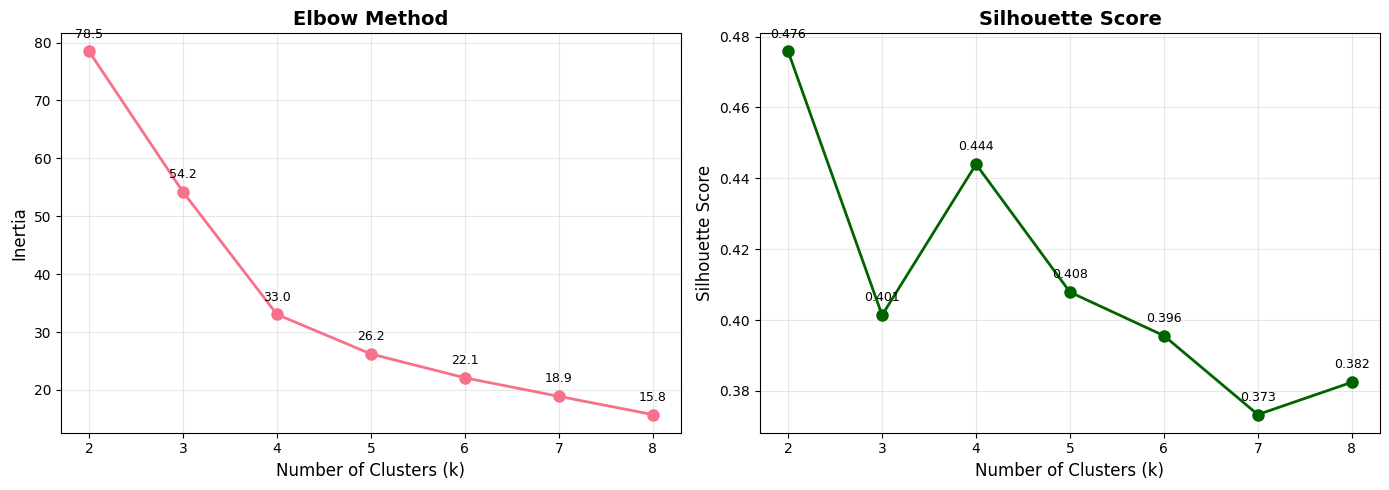


Performing K-means clustering with k=3...


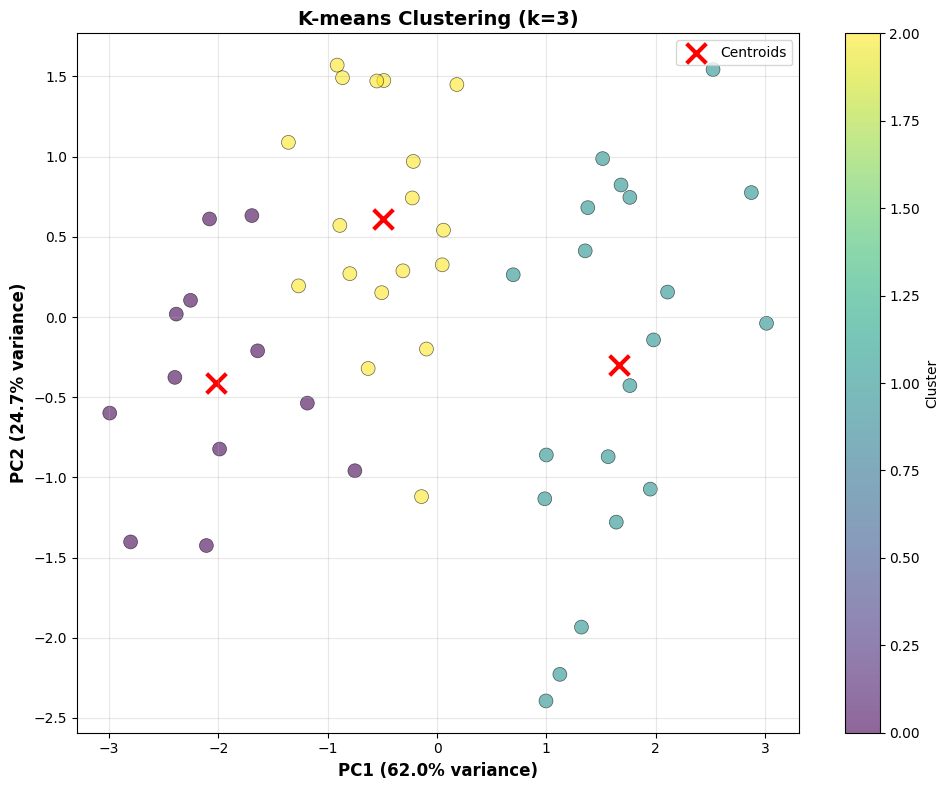


Silhouette Score: 0.40

K-means Cluster Analysis:

States in each cluster:

Cluster 0 (12 states):
Idaho, Iowa, Kentucky, Maine, Minnesota, Montana, New Hampshire, North Dakota, South Dakota, Vermont, West Virginia, Wisconsin

Cluster 1 (20 states):
Alabama, Alaska, Arizona, California, Colorado, Florida, Georgia, Illinois, Louisiana, Maryland, Michigan, Mississippi, Missouri, Nevada, New Mexico, New York, North Carolina, South Carolina, Tennessee, Texas

Cluster 2 (18 states):
Arkansas, Connecticut, Delaware, Hawaii, Indiana, Kansas, Massachusetts, Nebraska, New Jersey, Ohio, Oklahoma, Oregon, Pennsylvania, Rhode Island, Utah, Virginia, Washington, Wyoming

Average values for each cluster:
          Cluster 0  Cluster 1  Cluster 2
Variable                                 
Murder          3.5       12.2        5.8
Assault        76.6      255.2      139.7
UrbanPop       51.2       68.4       71.9
Rape           11.8       29.2       18.7

Cluster Analysis - Similarities within cluster

In [25]:
def evaluate_kmeans_clusters(data, max_k=8):
    """
    Tests different k values and plots elbow method and silhouette scores.
    """
    inertias = []
    sil_scores = []
    k_range = range(2, max_k + 1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        inertias.append(kmeans.inertia_)
        sil_scores.append(silhouette_score(data, labels))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(k_range, inertias, marker='o', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
    ax1.set_ylabel('Inertia', fontsize=12)
    ax1.set_title('Elbow Method', fontsize=14, fontweight='bold')
    ax1.set_xticks(k_range)
    ax1.grid(alpha=0.3)
    for k, inertia in zip(k_range, inertias):
        ax1.annotate(f'{inertia:.1f}', (k, inertia),
                    textcoords="offset points", xytext=(0, 10),
                    ha='center', fontsize=9)

    ax2.plot(k_range, sil_scores, marker='o', linewidth=2, markersize=8,
            color='darkgreen')
    ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
    ax2.set_ylabel('Silhouette Score', fontsize=12)
    ax2.set_title('Silhouette Score', fontsize=14, fontweight='bold')
    ax2.set_xticks(k_range)
    ax2.grid(alpha=0.3)
    for k, score in zip(k_range, sil_scores):
        ax2.annotate(f'{score:.3f}', (k, score),
                    textcoords="offset points", xytext=(0, 10),
                    ha='center', fontsize=9)

    fig.tight_layout()
    plt.savefig("images/kmeans_evaluation.png")
    plt.show()

    return inertias, sil_scores


def perform_kmeans_clustering(data, n_clusters=3):
    """
    Runs K-means clustering and shows the results on a plot.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data)
    sil_score = silhouette_score(data, labels)

    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(
        data[:, 0],
        data[:, 1],
        c=labels,
        cmap='viridis',
        s=100,
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5
    )
    ax.scatter(
        kmeans.cluster_centers_[:, 0],
        kmeans.cluster_centers_[:, 1],
        c='red',
        marker='x',
        s=200,
        linewidths=3,
        label='Centroids'
    )
    ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}% variance)',
                 fontsize=12, fontweight='bold')
    ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}% variance)',
                 fontsize=12, fontweight='bold')
    ax.set_title(f'K-means Clustering (k={n_clusters})', fontsize=14,
                fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Cluster')
    plt.tight_layout()
    plt.savefig("images/kmeans_clustering.png")
    plt.show()

    return kmeans, labels, sil_score


def analyze_clusters(labels, state_names, original_data):
    """
    Shows which states are in each cluster and their average crime stats.
    """
    cluster_data = pd.DataFrame({
        'State': state_names,
        'Cluster': labels
    })

    print("\nStates in each cluster:")
    print("="*50)
    for cluster_id in sorted(np.unique(labels)):
        cluster_states = cluster_data[
            cluster_data['Cluster'] == cluster_id
        ]['State'].tolist()
        print(f"\nCluster {cluster_id} ({len(cluster_states)} states):")
        print(", ".join(cluster_states))

    print("\n" + "="*50)
    print("Average values for each cluster:")
    print("="*50)

    cluster_means = pd.DataFrame()
    for cluster_id in sorted(np.unique(labels)):
        cluster_states = cluster_data[
            cluster_data['Cluster'] == cluster_id
        ]['State']
        cluster_means[f'Cluster {cluster_id}'] = (
            original_data.loc[cluster_states].mean()
        )

    cluster_means.index.name = 'Variable'
    print(cluster_means.round(1))

    print("\n" + "="*50)
    print("Cluster Analysis - Similarities within clusters:")
    print("="*50)
    for cluster_id in sorted(np.unique(labels)):
        cluster_states = cluster_data[
            cluster_data['Cluster'] == cluster_id
        ]['State']
        cluster_data_subset = original_data.loc[cluster_states]
        print(f"\nCluster {cluster_id}:")
        print(f"  Number of states: {len(cluster_states)}")
        means = cluster_data_subset.mean()
        print(f"  Average Murder rate: {means['Murder']:.2f}")
        print(f"  Average Assault rate: {means['Assault']:.2f}")
        print(f"  Average UrbanPop: {means['UrbanPop']:.2f}%")
        print(f"  Average Rape rate: {means['Rape']:.2f}")
        print(f"  Similarity: States in this cluster have similar")
        print(f"    patterns of crime rates and urbanization.")


print("Evaluating K-means for different k values...")
inertias, sil_scores = evaluate_kmeans_clusters(pca_scores)

print("\nPerforming K-means clustering with k=3...")
kmeans, kmeans_labels, kmeans_sil = perform_kmeans_clustering(
    pca_scores,
    n_clusters=3
)
print(f"\nSilhouette Score: {kmeans_sil:.2f}")

print("\nK-means Cluster Analysis:")
print("="*50)
analyze_clusters(kmeans_labels, data.index, data)


### Step 8.2: Hierarchical Clustering

Creating functions to perform hierarchical clustering:


Performing Hierarchical Clustering...


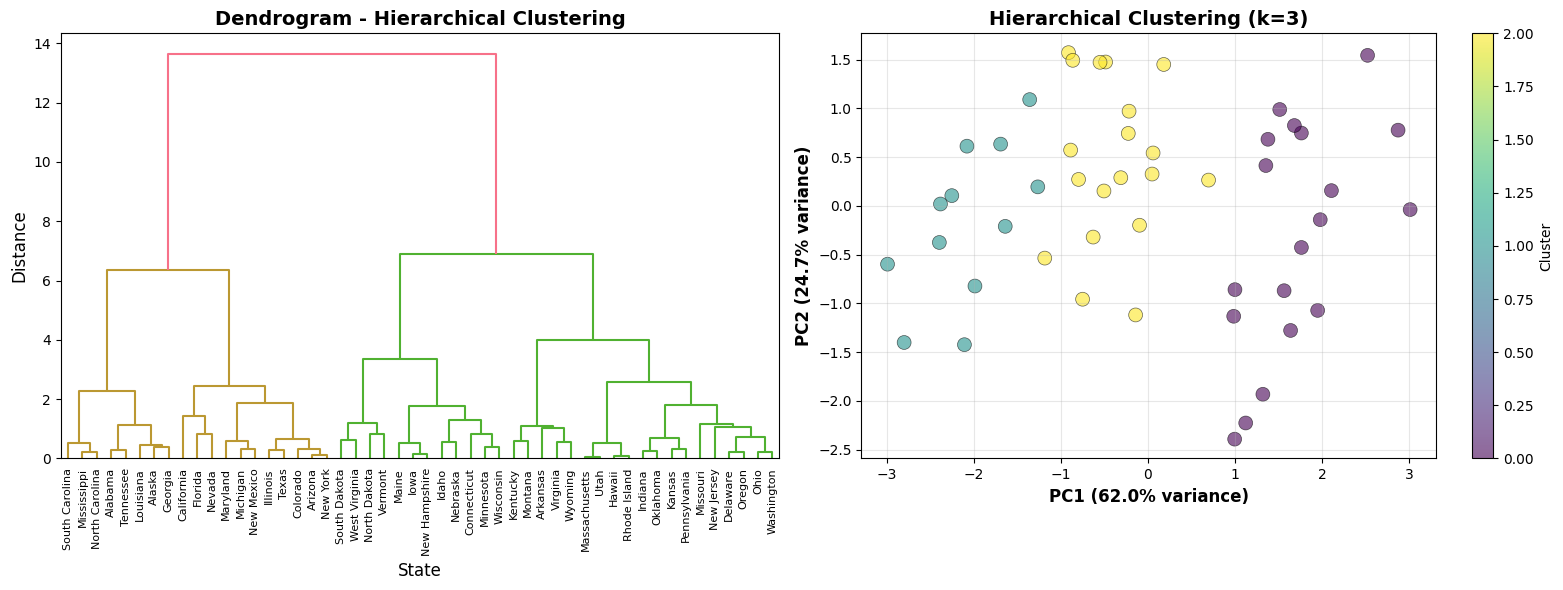


Silhouette Score: 0.38

Hierarchical Cluster Analysis:

States in each cluster:

Cluster 0 (19 states):
Alabama, Alaska, Arizona, California, Colorado, Florida, Georgia, Illinois, Louisiana, Maryland, Michigan, Mississippi, Nevada, New Mexico, New York, North Carolina, South Carolina, Tennessee, Texas

Cluster 1 (12 states):
Connecticut, Idaho, Iowa, Maine, Minnesota, Nebraska, New Hampshire, North Dakota, South Dakota, Vermont, West Virginia, Wisconsin

Cluster 2 (19 states):
Arkansas, Delaware, Hawaii, Indiana, Kansas, Kentucky, Massachusetts, Missouri, Montana, New Jersey, Ohio, Oklahoma, Oregon, Pennsylvania, Rhode Island, Utah, Virginia, Washington, Wyoming

Average values for each cluster:
          Cluster 0  Cluster 1  Cluster 2
Variable                                 
Murder         12.3        2.9        6.4
Assault       259.3       76.1      142.0
UrbanPop       68.3       54.1       70.0
Rape           29.2       11.4       19.5

Cluster Analysis - Similarities within cl

In [26]:
def perform_hierarchical_clustering(data, state_names, n_clusters=3,
                                   method='ward'):
    """
    Does hierarchical clustering and makes a dendrogram.
    """
    linked = linkage(data, method=method)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    dendrogram(
        linked,
        labels=state_names.values,
        ax=ax1,
        leaf_rotation=90,
        leaf_font_size=8
    )
    ax1.set_title('Dendrogram - Hierarchical Clustering',
                 fontsize=14, fontweight='bold')
    ax1.set_xlabel('State', fontsize=12)
    ax1.set_ylabel('Distance', fontsize=12)

    labels = fcluster(linked, n_clusters, criterion='maxclust')
    labels = labels - 1
    sil_score = silhouette_score(data, labels)

    scatter = ax2.scatter(
        data[:, 0],
        data[:, 1],
        c=labels,
        cmap='viridis',
        s=100,
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5
    )
    ax2.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}% variance)',
                   fontsize=12, fontweight='bold')
    ax2.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}% variance)',
                   fontsize=12, fontweight='bold')
    ax2.set_title(f'Hierarchical Clustering (k={n_clusters})',
                 fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)
    plt.colorbar(scatter, ax=ax2, label='Cluster')
    fig.tight_layout()
    plt.savefig("images/hierarchical_clustering.png")
    plt.show()

    return linked, labels, sil_score


print("Performing Hierarchical Clustering...")
linked, hierarchical_labels, hier_sil = perform_hierarchical_clustering(
    pca_scores,
    data.index,
    n_clusters=3
)
print(f"\nSilhouette Score: {hier_sil:.2f}")

print("\nHierarchical Cluster Analysis:")
print("="*50)
analyze_clusters(hierarchical_labels, data.index, data)


### Step 8.3: Comparison of Clustering Methods

Comparing K-means and Hierarchical clustering to see how similar the results are and which states are assigned differently.


Comparing K-means and Hierarchical Clustering Results:
Agreement between methods: 32.0%

States with different cluster assignments:

Total states with different assignments: 34



,State,K-means,Hierarchical
1,Alabama,1,0
2,Alaska,1,0
3,Arizona,1,0
4,California,1,0
5,Colorado,1,0
6,Connecticut,2,1
7,Florida,1,0
8,Georgia,1,0
9,Idaho,0,1
10,Illinois,1,0


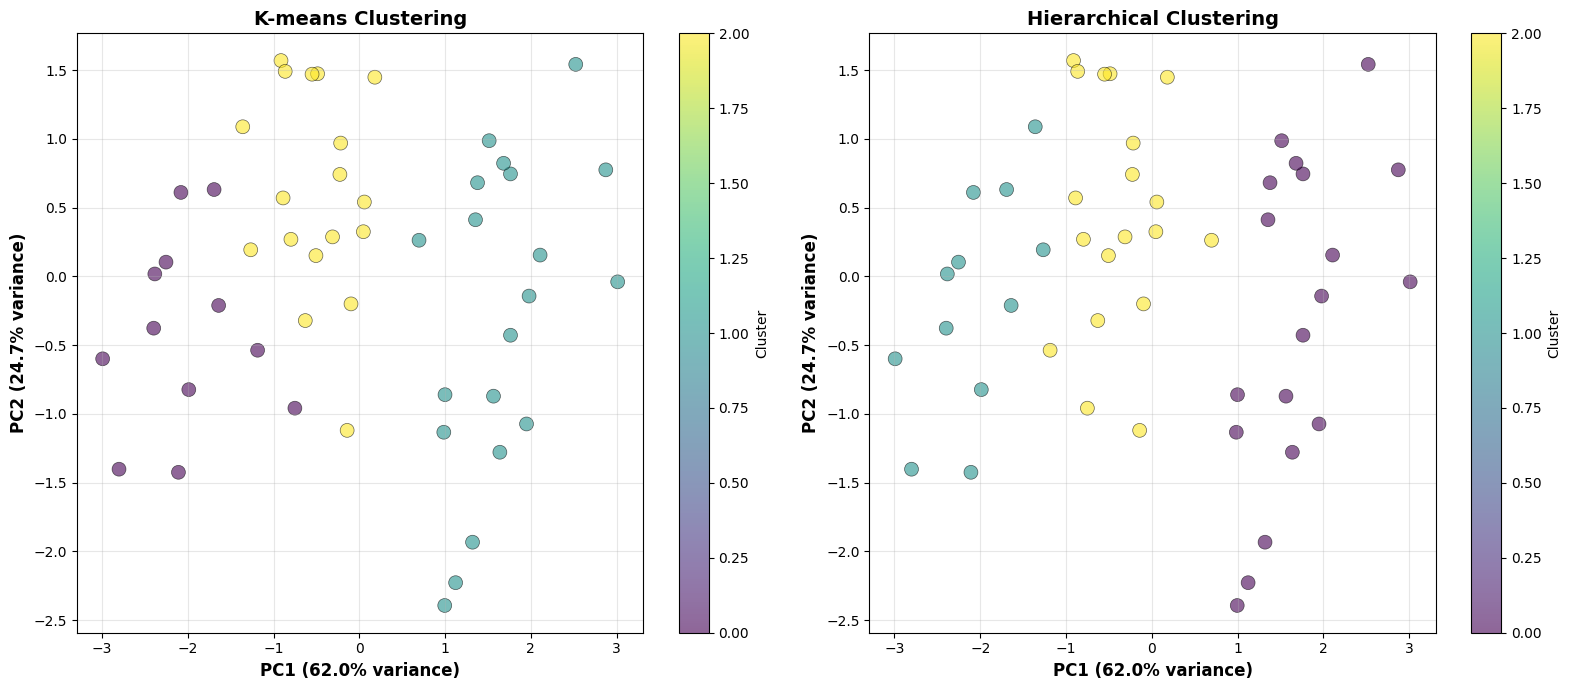

In [27]:
def compare_clustering_methods(labels1, labels2, state_names, data_pca):
    """
    Compares K-means and hierarchical clustering results side by side.
    """
    agreement = np.sum(labels1 == labels2) / len(labels1) * 100

    print(f"Agreement between methods: {agreement:.1f}%")
    print("\nStates with different cluster assignments:")
    print("="*50)

    differences = []
    for i, state in enumerate(state_names):
        if labels1[i] != labels2[i]:
            differences.append({
                'State': state,
                'K-means': labels1[i],
                'Hierarchical': labels2[i]
            })

    if not differences:
        print("All states have the same cluster assignment in both methods.")
    else:
        differences_df = pd.DataFrame(differences)
        differences_df = differences_df.sort_values('State')
        differences_df = differences_df.reset_index(drop=True)
        differences_df.index = differences_df.index + 1
        print(f"\nTotal states with different assignments: {len(differences_df)}")
        print("\n" + "="*60)
        display(differences_df)
        print("="*60)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    scatter1 = ax1.scatter(
        data_pca[:, 0],
        data_pca[:, 1],
        c=labels1,
        cmap='viridis',
        s=100,
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5
    )
    ax1.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}% variance)',
                   fontsize=12, fontweight='bold')
    ax1.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}% variance)',
                   fontsize=12, fontweight='bold')
    ax1.set_title('K-means Clustering', fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)
    plt.colorbar(scatter1, ax=ax1, label='Cluster')

    scatter2 = ax2.scatter(
        data_pca[:, 0],
        data_pca[:, 1],
        c=labels2,
        cmap='viridis',
        s=100,
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5
    )
    ax2.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}% variance)',
                   fontsize=12, fontweight='bold')
    ax2.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}% variance)',
                   fontsize=12, fontweight='bold')
    ax2.set_title('Hierarchical Clustering', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)
    plt.colorbar(scatter2, ax=ax2, label='Cluster')

    fig.tight_layout()
    plt.savefig("images/clustering_comparison.png")
    plt.show()


print("Comparing K-means and Hierarchical Clustering Results:")
print("="*50)
compare_clustering_methods(
    kmeans_labels,
    hierarchical_labels,
    data.index,
    pca_scores
)


## Summary and Conclusions

This notebook performed an unsupervised learning analysis on the US Arrests dataset. Here's what I did:

1. **Data Exploration**: Examined the dataset structure, checked for missing values, and looked at summary statistics.

2. **Data Preprocessing**: Standardized the data so all variables are on the same scale, which is essential for PCA.

3. **Correlation Analysis**: Found strong positive correlations between violent crime variables (Murder, Assault, Rape), which makes PCA appropriate for dimensionality reduction.

4. **Principal Component Analysis**: Reduced the 4-dimensional data to 2 principal components that capture 86.75% of the variance, which allows for clear visualization and interpretation.

5. **Component Selection**: Selected 2 components based on variance threshold (80%+), scree plot analysis, and interpretability.

6. **Biplot Visualization**: Visualized both states and variables in the PCA space, which revealed patterns in crime rates and urbanization across US states.

7. **Clustering Analysis**: Applied two clustering techniques:
   - **K-means**: Partitioned states into 3 clusters based on similarity
   - **Hierarchical**: Built a hierarchy of clusters using agglomerative approach
   - Both methods identified similar groups of states with comparable crime and urbanization patterns

**Key Findings:**
- States within each cluster show similar patterns of crime rates (Murder, Assault, Rape) and urbanization levels
- Clusters represent distinct groups: high-crime urban states, low-crime rural states, and moderate-crime states
- The clustering methods show some agreement on state groupings, though there are differences in how some states are classified
